In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
from tqdm.notebook import tqdm
from data_tools import get_data_with_dates, get_verified_data
from warnings import warn

sns.set(rc={"figure.figsize":(16, 10)})

In [2]:
def get_data(filename: str, crisis_start: pd.Timestamp):
    src_df = pd.read_excel(filename)
    
    new_cols = ['brak', 'negatywny', 'neutralny', 'pozytywny']
    new_cols_ex = [c for c in new_cols if c in src_df['Wydźwięk'].unique().tolist()]
    src_df[new_cols_ex] = pd.get_dummies(src_df['Wydźwięk'])
    for col in new_cols:
        if col not in src_df.columns:
            src_df[col] = 0

    df = src_df[['Data wydania'] + new_cols].groupby(['Data wydania']).sum()

    df = df.reindex(pd.date_range(df.index.min(), df.index.max()))
    df[new_cols] = df[new_cols].fillna(0)

    df['Liczba wpisów'] = df[new_cols].sum(axis=1)
    df['Kryzys'] = df.index >= crisis_start
    return df

def plot1(df: pd.DataFrame):
    ax = sns.lineplot(df[['Wydźwięk', 'Liczba wpisów']], x='Data wydania', y='Liczba wpisów', hue='Wydźwięk')
    ax.fill_between(df.index, 0, 1, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())

def plot2(df: pd.DataFrame, title: str = None, prediction: pd.Timestamp = None):
    ax = plt.stackplot(x=df.index, data=df[['pozytywny', 'negatywny', 'neutralny', 'brak']])
    ax.fill_between(df.index, 0, 1, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())
    if 'prediction' in df.columns:
        ax.fill_between(df.index, 0, 1, where=df['prediction'], color='blue', alpha=0.5, transform=ax.get_xaxis_transform())
    if title:
        ax.set_title(title)

In [8]:
def extract_raw_data(filename: str) -> pd.DataFrame:
    src_df = pd.read_excel(filename)

    if src_df['Kryzys'].hasnans:
        src_df['Kryzys'] = src_df['Kryzys'].notna()
    else:
        src_df['Kryzys'] = (src_df['Kryzys'] != 'NIE') & (src_df['Kryzys'] != 'Nie')
    if src_df['Kryzys'].nunique() != 2:
        warn(f'Crisis column data error in file {filename}.')
    
    new_cols = ['brak', 'negatywny', 'neutralny', 'pozytywny']
    new_cols_ex = [c for c in new_cols if c in src_df['Wydźwięk'].unique().tolist()]
    src_df[new_cols_ex] = pd.get_dummies(src_df['Wydźwięk'])
    for col in new_cols:
        if col not in src_df.columns:
            src_df[col] = 0

    df = src_df[['Data wydania', 'Kryzys']].groupby(['Data wydania']).any()
    df = df.join(src_df[['Data wydania'] + new_cols].groupby(['Data wydania']).sum())

    df = df.reindex(pd.date_range(df.index.min(), df.index.max()))
    df[new_cols] = df[new_cols].fillna(0)
    df['Kryzys'] = df['Kryzys'].fillna(method='ffill') & df['Kryzys'].fillna(method='bfill')

    # df['suma'] = df[new_cols].sum(axis=1)

    df['nazwa'] = os.path.basename(filename)[:-5]
    
    return df

In [13]:
def plot3(df_row: pd.Series):
    df = extract_raw_data(df_row['path'])
    _, ax = plt.subplots()
    ax.stackplot(
        df.index.values,
        df[[ 'brak', 'negatywny', 'pozytywny', 'neutralny']].to_dict('list').values(),
        labels=['brak', 'negatywny', 'pozytywny', 'neutralny'],
        colors=['gray', 'red', 'green', 'blue'],
        edgecolor='face'
    )
    ax.fill_between(df.index, 0, 1, where=df['Kryzys'], color='red', alpha=0.1, transform=ax.get_xaxis_transform())
    ax.fill_between(df.index, 0, 1, where=(df.index == df_row['Data']), color='black', alpha=1, transform=ax.get_xaxis_transform())
    ax.legend()
    ax.set_title(os.path.basename(df_row['path'])[:-5])

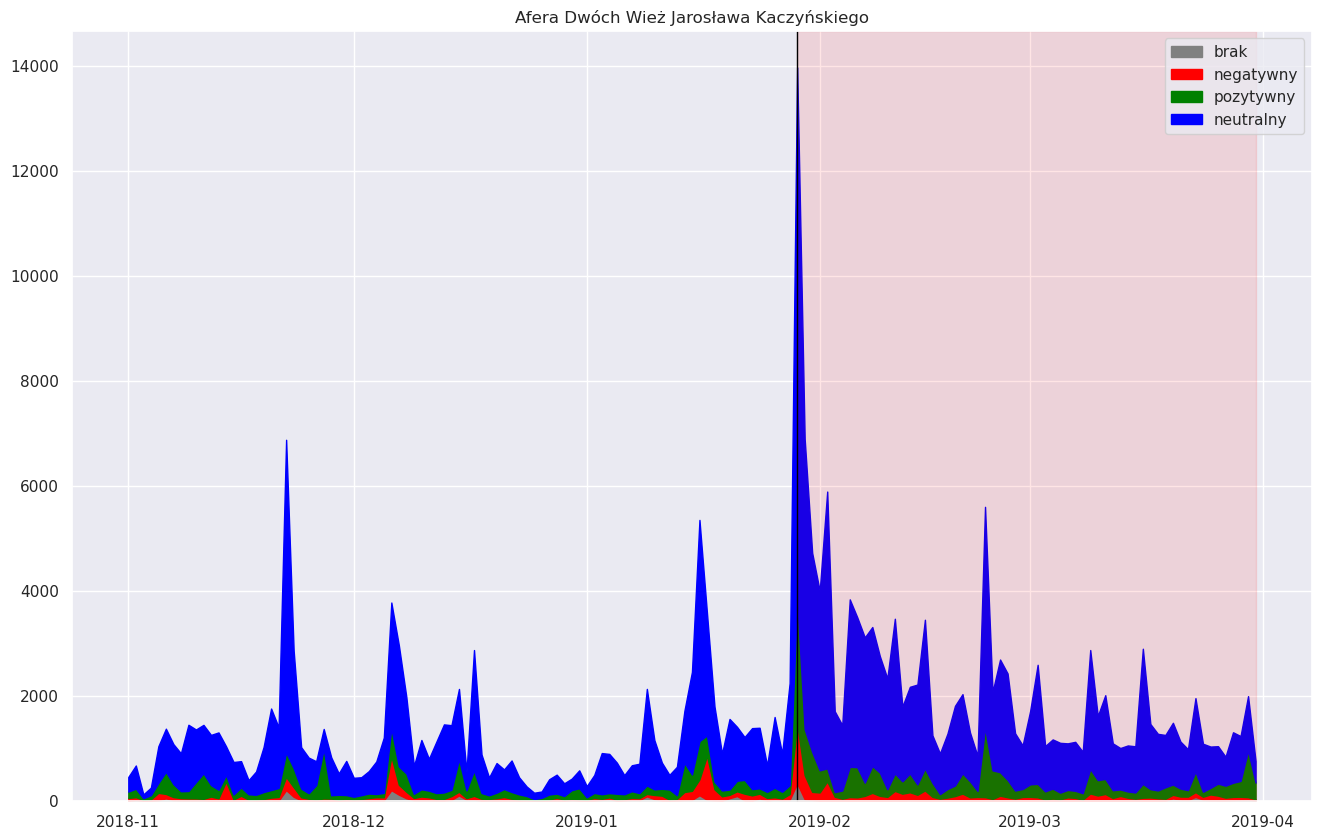

In [14]:
plot3(data.iloc[0])

In [ ]:
dfs = [extract_raw_data(fname).reset_index() for fname in tqdm(files)]
df = pd.concat(dfs, ignore_index=True)

In [ ]:
df['suma'].value_counts()

In [ ]:
sns.histplot(data=df, x='suma')
plt.ylim(0, 1000)
plt.xlim(0, 500)


In [ ]:
sns.histplot(data=df[['nazwa', 'suma']].groupby('nazwa').count().reset_index(), x='suma', binwidth=10)
plt.xlim(0, 500)

In [ ]:
sns.histplot(data=df[['nazwa', 'suma']].groupby('nazwa').sum().reset_index(), x='suma')

In [ ]:
df = get_data(files[0])

In [ ]:
df = extract_raw_data(data['path'].iloc[1])
fig, ax = plt.subplots()
ax.stackplot(df.index.values, df[['pozytywny', 'negatywny', 'neutralny', 'brak']].to_dict('list').values(), labels=['pozytywny', 'negatywny', 'neutralny', 'brak'])
ax.legend()

In [ ]:
df.index.values

In [ ]:
df[['pozytywny', 'negatywny', 'neutralny', 'brak']].to_dict('list').values()

In [ ]:
plot2(extract_raw_data(data['path'].iloc[0]), os.path.basename(data['path'].iloc[0]), data['Data'].iloc[0])
# plt.savefig('test.png')

In [ ]:
with open('other_data/shifts.json', 'r') as f:
    shifts = json.load(f)

In [ ]:
df = crisis[crisis['Plik'].isin(shifts.keys())].reset_index()
shifts_df = pd.DataFrame.from_dict(shifts, orient='index').reset_index().rename(columns={'index': 'Plik', 0: 'shift'})
shifts_df['shift'] = shifts_df['shift'].apply(lambda x: pd.Timedelta(days=x))
df['prediction'] = df['Data'] + shifts_df['shift']

In [15]:
data = get_data_with_dates(get_verified_data())

for i in tqdm(range(len(data))):
    plot3(data.iloc[i])
    plt.savefig(os.path.join('plots', os.path.basename(data.iloc[i]['path'])[:-5] + '.png'))
    plt.close()

/home/proto/repos/crisis-detector/data_tools.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates1['path'] = dates1['Plik'].apply(lambda x: files[fnames.index(x)])


  0%|          | 0/89 [00:00<?, ?it/s]

/tmp/ipykernel_5664/3953965445.py:9: UserWarning: Crisis column data error in file dane/Etap I - zweryfikowane szeregi/Ministerstwo Zdrowia_respiratory od handlarza bronią.xlsx.
  warn(f'Crisis column data error in file {filename}.')


In [5]:
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    df2 = get_data(os.path.join(DATA_DIR, row.Plik), row.Data)
    df2['prediction'] = df2.index == row.prediction
    plot2(df2, row.Plik[:-5])

NameError: name 'df' is not defined